In [29]:

import pandas as pd
import mlflow
import seaborn as sns
from mlflow.models.signature import infer_signature
import mlflow.sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import shap
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import joblib
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, RocCurveDisplay
client = mlflow.tracking.MlflowClient()

In [30]:
mlflow.set_tracking_uri(uri="http://127.0.0.1:5000")


In [31]:
# Load processed data
df = pd.read_csv("../data/processed_insurance_data.csv")
X = df.drop("fraud_reported", axis=1)
y = df["fraud_reported"]


In [32]:
## Apply standard scaling to numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)


In [33]:
# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, stratify=y, test_size=0.2, random_state=42)
print("Train/Test sizes:", X_train.shape, X_test.shape)


Train/Test sizes: (800, 26) (200, 26)


In [34]:
experiment_name = "Auto Insurance Fraud Detection"

experiment_id = mlflow.set_experiment(experiment_name)

### Logistic Regression

In [35]:
# === Logistic Regression ===
with mlflow.start_run(run_name="LogisticRegression") as lr_run:
    mlflow.set_tag("model", "LogisticRegression")
    model = LogisticRegression(class_weight='balanced', random_state=42)
    model.fit(X_train, y_train)
    y_preds = model.predict(X_test)
    proba = model.predict_proba(X_test)[:, 1]

    auc = roc_auc_score(y_test, proba)
    report = classification_report(y_test, y_preds, output_dict=True)
    cm = confusion_matrix(y_test, y_preds)
    precision = report['1']['precision']
    recall = report['1']['recall']
    f1_score = report['1']['f1-score']
    accuracy = accuracy_score(y_test, y_preds)
    metrics = {
        'AUC': auc,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1_score,
        'Accuracy': accuracy
    }
    mlflow.log_metrics(metrics)
    mlflow.log_params(model.get_params())
    mlflow.log_param("model", "LogisticRegression")

    # Log model

    signature = infer_signature(X_train, model.predict(X_train))
    mlflow.sklearn.log_model(model, "LogisticRegression", signature=signature, input_example=X_train.iloc[:1])

    fpr, tpr, _ = roc_curve(y_test, proba)
    RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
    plt.title("ROC Curve - LogisticRegression")
    plt.savefig("../assets/roc_curve_LogisticRegression.png")
    mlflow.log_artifact("../assets/roc_curve_LogisticRegression.png")
    plt.close()

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title("Confusion Matrix - LogisticRegression")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.savefig("../assets/conf_matrix_LogisticRegression.png")
    mlflow.log_artifact("../assets/conf_matrix_LogisticRegression.png")
    plt.close()



🏃 View run LogisticRegression at: http://127.0.0.1:5000/#/experiments/147046143188902615/runs/2d56accef036474ba193e95818c54710
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/147046143188902615


/opt/anaconda3/envs/project_env/lib/python3.11/site-packages/sklearn/metrics/_plot/roc_curve.py:189: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  self.ax_.legend(loc="lower right")


### Random Forest

In [38]:
# === Random Forest ===
with mlflow.start_run(run_name="RandomForest") as rf_run:
    mlflow.set_tag("model", "RandomForest")
    model = RandomForestClassifier(
        n_estimators=100,
        max_depth=4,
        class_weight='balanced',
        random_state=42
    )
    model.fit(X_train, y_train)
    y_preds = model.predict(X_test)
    proba = model.predict_proba(X_test)[:, 1]

    auc = roc_auc_score(y_test, proba)
    report = classification_report(y_test, y_preds, output_dict=True)
    cm = confusion_matrix(y_test, y_preds)
    precision = report['1']['precision']
    recall = report['1']['recall']
    f1_score = report['1']['f1-score']
    accuracy = accuracy_score(y_test, y_preds)
    
    params = model.get_params()
    mlflow.log_params(params)
    mlflow.log_param("model", "RandomForest")
    # Log metrics
    metrics = {
        'AUC': auc, 
        'F1_score': f1_score,
        'Precision': precision,
        'Recall': recall,
        'Accuracy': accuracy
    }

    mlflow.log_metrics(metrics)

    signature = infer_signature(X_train, model.predict(X_train))
    mlflow.sklearn.log_model(model, "RandomForest", signature=signature, input_example=X_train.iloc[:1])

    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_train)
    shap.summary_plot(shap_values, X_train, plot_type="bar", show=False)
    plt.savefig("../assets/shap_summary_RandomForest.png")
    mlflow.log_artifact("../assets/shap_summary_RandomForest.png")
    plt.close()

    fpr, tpr, _ = roc_curve(y_test, proba)
    RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
    plt.title("ROC Curve - RandomForest")
    plt.savefig("roc_curve_RandomForest.png")
    mlflow.log_artifact("roc_curve_RandomForest.png")
    plt.close()

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title("Confusion Matrix - RandomForest")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.savefig("conf_matrix_RandomForest.png")
    mlflow.log_artifact("conf_matrix_RandomForest.png")
    plt.close()



🏃 View run RandomForest at: http://127.0.0.1:5000/#/experiments/147046143188902615/runs/f588c848fed345e3a89ebc1de24a5e7b
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/147046143188902615


/opt/anaconda3/envs/project_env/lib/python3.11/site-packages/sklearn/metrics/_plot/roc_curve.py:189: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  self.ax_.legend(loc="lower right")


<Figure size 640x480 with 0 Axes>

### XGBoost

/opt/anaconda3/envs/project_env/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [03:15:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


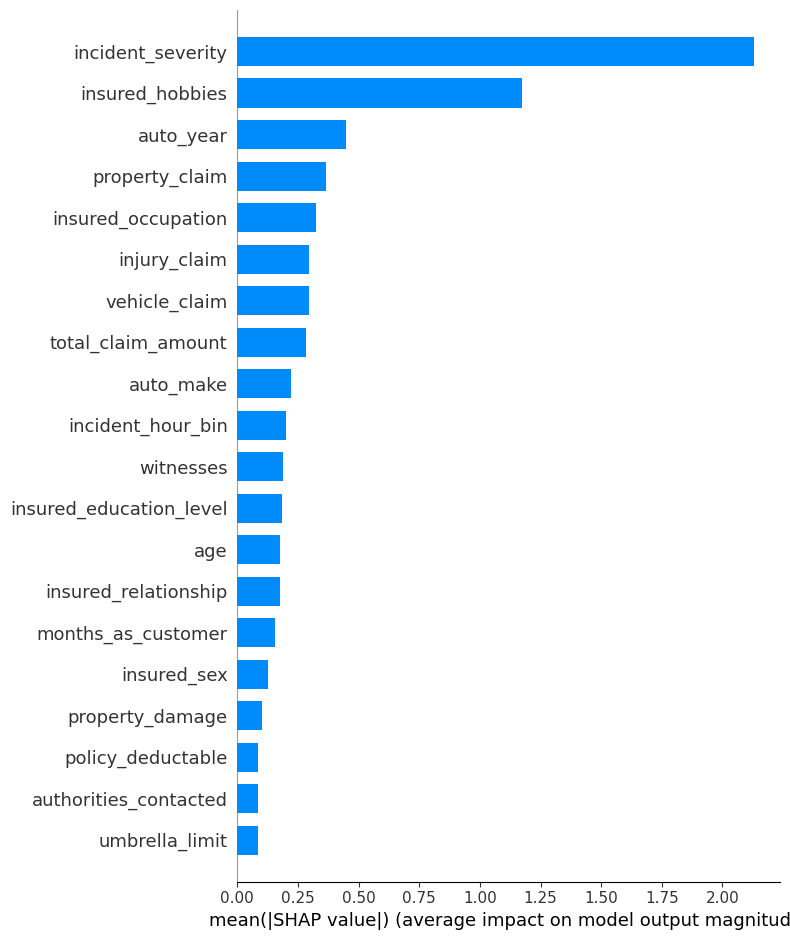

🏃 View run XGBoost at: http://127.0.0.1:5000/#/experiments/147046143188902615/runs/f3bda67dcf564c759636c5f5096361eb
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/147046143188902615
Model Parameters {'reg_lambda': 'None', 'colsample_bynode': 'None', 'gamma': 'None', 'multi_strategy': 'None', 'validate_parameters': 'None', 'max_cat_threshold': 'None', 'max_delta_step': 'None', 'monotone_constraints': 'None', 'colsample_bylevel': 'None', 'base_score': 'None', 'max_bin': 'None', 'max_depth': '4', 'booster': 'None', 'min_child_weight': 'None', 'learning_rate': 'None', 'objective': 'binary:logistic', 'random_state': 'None', 'scale_pos_weight': '1', 'verbosity': 'None', 'interaction_constraints': 'None', 'use_label_encoder': 'False', 'max_cat_to_onehot': 'None', 'num_parallel_tree': 'None', 'tree_method': 'None', 'model': 'XGBoost', 'grow_policy': 'None', 'device': 'None', 'max_leaves': 'None', 'sampling_method': 'None', 'n_jobs': 'None', 'colsample_bytree': 'None', 'eval_metric':

/opt/anaconda3/envs/project_env/lib/python3.11/site-packages/sklearn/metrics/_plot/roc_curve.py:189: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  self.ax_.legend(loc="lower right")


In [39]:
# === XGBoost ===
with mlflow.start_run(run_name="XGBoost") as xgb_run:
    mlflow.set_tag("model", "XGBoost")
    model = XGBClassifier(
        n_estimators=100,
        max_depth=4,
        use_label_encoder=False,
        eval_metric='auc',
        scale_pos_weight=1
)
    model.fit(X_train, y_train)
    y_preds = model.predict(X_test)
    proba = model.predict_proba(X_test)[:, 1]

    auc = roc_auc_score(y_test, proba)
    report = classification_report(y_test, y_preds, output_dict=True)
    precision = report['1']['precision']
    recall = report['1']['recall']
    f1_score = report['1']['f1-score']
    accuracy = accuracy_score(y_test, y_preds)
    cm = confusion_matrix(y_test, y_preds)
    params = model.get_xgb_params()

    mlflow.log_params(params)
    mlflow.log_param("model", "XGBoost")

    # Log metrics
    metrics = {
        'AUC': auc, 
        'F1_score': f1_score,
        'Precision': precision,
        'Recall': recall,
        'Accuracy': accuracy
    }

    mlflow.log_metrics(metrics)

    signature = infer_signature(X_train, model.predict(X_train))
    mlflow.sklearn.log_model(model, "XGBoost", signature=signature, input_example=X_train.iloc[:1])

    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_train)
    shap.summary_plot(shap_values, X_train, plot_type="bar")
    plt.savefig("../assets/shap_summary_XGBoost.png")
    mlflow.log_artifact("../assets/shap_summary_XGBoost.png")
    plt.close()

    fpr, tpr, _ = roc_curve(y_test, proba)
    RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
    plt.title("ROC Curve - XGBoost")
    plt.savefig("../assets/roc_curve_XGBoost.png")
    mlflow.log_artifact("../assets/roc_curve_XGBoost.png")
    plt.close()

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title("Confusion Matrix - XGBoost")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.savefig("../assets/conf_matrix_XGBoost.png")
    mlflow.log_artifact("../assets/conf_matrix_XGBoost.png")
    plt.close()

print('Model Parameters', client.get_run(xgb_run.info.run_id).data.params)
print('Metrics', client.get_run(xgb_run.info.run_id).data.metrics)

### Support Vector Machine

In [41]:
svm_model = SVC(kernel='rbf', C=1.0, probability=True, random_state=42, class_weight='balanced')

with mlflow.start_run(run_name="SVM") as svm_run:
    mlflow.set_tag("model", "SVM")
    svm_model.fit(X_train, y_train)
    preds = svm_model.predict(X_test)
    probas = svm_model.predict_proba(X_test)[:, 1]

    auc = roc_auc_score(y_test, probas)
    report = classification_report(y_test, preds, output_dict=True)
    cm = confusion_matrix(y_test, preds)
    precision = report['1']['precision']
    recall = report['1']['recall']
    f1_score = report['1']['f1-score']
    accuracy = accuracy_score(y_test, preds)
    params = svm_model.get_params()
    mlflow.log_params(params)
    mlflow.log_param("model", "SVM")

    
    # Log metrics
    metrics = {
        'AUC': auc, 
        'F1_score': f1_score,
        'Precision': precision,
        'Recall': recall,
        'Accuracy': accuracy
    }
    mlflow.log_metrics(metrics)

    # Log model
    signature = infer_signature(X_train, model.predict(X_train))
    mlflow.sklearn.log_model(svm_model, "SVM", signature=signature, input_example=X_train.iloc[:1])


    # Log Confusion Matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title("SVM Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.savefig("../assets/svm_confusion_matrix.png")
    mlflow.log_artifact("../assets/svm_confusion_matrix.png")
    plt.close()

    # ROC Curve
    from sklearn.metrics import RocCurveDisplay
    RocCurveDisplay.from_estimator(svm_model, X_test, y_test)
    plt.title("SVM ROC Curve")
    plt.savefig("../assets/svm_roc_curve.png")
    mlflow.log_artifact("../assets/svm_roc_curve.png")
    plt.close()

print("SVM model logged to MLflow.")

🏃 View run SVM at: http://127.0.0.1:5000/#/experiments/147046143188902615/runs/a1a69c6371864e689768b442b9a8140c
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/147046143188902615
SVM model logged to MLflow.


In [42]:
## get experiment details

experiment = client.get_experiment_by_name(experiment_name)
runs = mlflow.search_runs(experiment_ids=[experiment.experiment_id], order_by=['metrics.AUC DESC'])
runs

,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.Recall,metrics.AUC,metrics.F1_score,metrics.Accuracy,...,params.fit_intercept,params.dual,params.solver,params.l1_ratio,tags.mlflow.user,tags.mlflow.runName,tags.model,tags.mlflow.source.name,tags.mlflow.source.type,tags.mlflow.log-model.history
0,f3bda67dcf564c759636c5f5096361eb,147046143188902615,FINISHED,/Users/fatimatatanda/Library/CloudStorage/OneD...,2025-05-31 08:15:55.476000+00:00,2025-05-31 08:15:57.576000+00:00,0.653061,0.828085,0.680851,0.850,...,None,None,None,None,fatimatatanda,XGBoost,XGBoost,/opt/anaconda3/envs/project_env/lib/python3.11...,LOCAL,"[{""run_id"": ""f3bda67dcf564c759636c5f5096361eb""..."
1,f588c848fed345e3a89ebc1de24a5e7b,147046143188902615,FINISHED,/Users/fatimatatanda/Library/CloudStorage/OneD...,2025-05-31 08:15:11.047000+00:00,2025-05-31 08:15:13.214000+00:00,0.816327,0.825652,0.707965,0.835,...,None,None,None,None,fatimatatanda,RandomForest,RandomForest,/opt/anaconda3/envs/project_env/lib/python3.11...,LOCAL,"[{""run_id"": ""f588c848fed345e3a89ebc1de24a5e7b""..."
2,a1a69c6371864e689768b442b9a8140c,147046143188902615,FINISHED,/Users/fatimatatanda/Library/CloudStorage/OneD...,2025-05-31 08:16:41.656000+00:00,2025-05-31 08:16:43.643000+00:00,0.755102,0.820854,0.556391,0.705,...,None,None,None,None,fatimatatanda,SVM,SVM,/opt/anaconda3/envs/project_env/lib/python3.11...,LOCAL,"[{""run_id"": ""a1a69c6371864e689768b442b9a8140c""..."
3,2d56accef036474ba193e95818c54710,147046143188902615,FINISHED,/Users/fatimatatanda/Library/CloudStorage/OneD...,2025-05-31 08:14:28.165000+00:00,2025-05-31 08:14:30.147000+00:00,0.795918,0.815245,NaN,0.680,...,True,False,lbfgs,None,fatimatatanda,LogisticRegression,LogisticRegression,/opt/anaconda3/envs/project_env/lib/python3.11...,LOCAL,"[{""run_id"": ""2d56accef036474ba193e95818c54710""..."
4,121ccc109d3a45b18a718bad125947dc,147046143188902615,FINISHED,/Users/fatimatatanda/Library/CloudStorage/OneD...,2025-05-31 08:14:10.944000+00:00,2025-05-31 08:14:14.106000+00:00,NaN,NaN,NaN,NaN,...,None,None,None,None,fatimatatanda,EDA and Feature Engineering,None,/opt/anaconda3/envs/project_env/lib/python3.11...,LOCAL,None


In [44]:
best_run_id = runs.iloc[0]["run_id"]
best_model_name = runs.iloc[0]["params.model"]
print(f"\nBest Run ID: {best_run_id}, Model: {best_model_name}, \nAUC: {runs.iloc[0]['metrics.AUC']:.3f}, \nF1-Score: {runs.iloc[0]['metrics.F1_score']:.3f}, \nPrecision: {runs.iloc[0]['metrics.Precision']:.3f}, \nRecall: {runs.iloc[0]['metrics.Recall']:.3f}, \nAccuracy: {runs.iloc[0]['metrics.Accuracy']:.3f}")




Best Run ID: f3bda67dcf564c759636c5f5096361eb, Model: XGBoost, 
AUC: 0.828, 
F1-Score: 0.681, 
Precision: 0.711, 
Recall: 0.653, 
Accuracy: 0.850


In [45]:
# register the model from best run
model_uri = f"runs:/{best_run_id}/{best_model_name}"
registered_model_name = "AutoInsuranceFraudModel"

mlflow.register_model(model_uri=model_uri, name=registered_model_name)

print(f"\nRegistered model '{registered_model_name}' from run {best_run_id}")

Successfully registered model 'AutoInsuranceFraudModel'.
2025/05/31 03:20:43 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: AutoInsuranceFraudModel, version 1



Registered model 'AutoInsuranceFraudModel' from run f3bda67dcf564c759636c5f5096361eb


Created version '1' of model 'AutoInsuranceFraudModel'.
